In [32]:
from sentence_transformers import SentenceTransformer
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import random
import torch
import torch.nn as nn
from torch_geometric.utils import from_networkx
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from sklearn.decomposition import PCA
from torch_geometric.loader import NeighborLoader
import pandas as pd
import numpy as np




In [33]:
rating_df = pd.read_csv('rating.csv')
anime_df = pd.read_csv('anime.csv')

In [34]:
rating_df.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [35]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


In [36]:
rating_df.isna().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [37]:
anime_df.isna().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

In [38]:
anime_rating_mean = anime_df['rating'].mean()
anime_df['rating'] = anime_df['rating'].fillna(anime_rating_mean)

In [39]:
anime_df.dropna()


,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover: Minami tai Mecha-Minami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,OVA,1,4.98,175


In [40]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [41]:
anime_df['genre'] = anime_df['genre'].fillna("Unknown")
anime_df['genre'] = anime_df['genre'].astype(str)  # Convert all values to string

genre_embeddings = model.encode(anime_df['genre'].tolist(), convert_to_tensor=True)


In [42]:
genre_embeddings

tensor([[ 0.0279, -0.1049,  0.0457,  ..., -0.0214,  0.0039,  0.0108],
        [ 0.0158, -0.0546, -0.0091,  ..., -0.0429, -0.0500,  0.0712],
        [-0.0754, -0.1026, -0.0215,  ..., -0.0219,  0.0050,  0.0343],
        ...,
        [-0.0443, -0.0638,  0.0439,  ...,  0.0337,  0.0472, -0.0632],
        [-0.0443, -0.0638,  0.0439,  ...,  0.0337,  0.0472, -0.0632],
        [-0.0443, -0.0638,  0.0439,  ...,  0.0337,  0.0472, -0.0632]],
       device='cuda:0')

In [43]:
anime_df['genre_embedding'] = list(genre_embeddings.cpu().numpy())  


anime_df.head()

,anime_id,name,genre,type,episodes,rating,members,genre_embedding
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630,"[0.027858414, -0.10489936, 0.04573688, 0.05266..."
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665,"[0.01584947, -0.054560315, -0.009054665, -0.02..."
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262,"[-0.07539095, -0.10257964, -0.021513062, -0.03..."
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,"[-0.045288168, -0.009361077, -0.046599023, 0.0..."
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,"[-0.07539095, -0.10257964, -0.021513062, -0.03..."


In [44]:
G = nx.Graph()

user_ids = rating_df['user_id'].unique()
G.add_nodes_from(user_ids,bipartite=0, type="user")

anime_ids = anime_df['anime_id'].unique()
G.add_nodes_from(anime_ids,bipartite=1,type="anime")





In [45]:
rating_np = rating_df[["user_id", "anime_id", "rating"]].to_numpy()
G.add_weighted_edges_from(rating_np)

In [46]:
anime_embeddings = np.vstack(anime_df["genre_embedding"].values)

similarity_matrix = cosine_similarity(anime_embeddings)

print(similarity_matrix)

[[1.         0.63451874 0.51078176 ... 0.3399033  0.3399033  0.3399033 ]
 [0.63451874 1.0000002  0.73506415 ... 0.30226475 0.30226475 0.30226475]
 [0.51078176 0.73506415 1.0000001  ... 0.3466016  0.3466016  0.3466016 ]
 ...
 [0.3399033  0.30226475 0.3466016  ... 1.         1.         1.        ]
 [0.3399033  0.30226475 0.3466016  ... 1.         1.         1.        ]
 [0.3399033  0.30226475 0.3466016  ... 1.         1.         1.        ]]


In [47]:
num_of_similar = 5
similar_anime_edges = []

for idx,anime_id in enumerate(anime_df['anime_id']):
    similar_indices = np.argsort(similarity_matrix[idx][-num_of_similar-1:-1])

    for sim_idx in similar_indices:
        sim_anime_id = anime_df.iloc[sim_idx]["anime_id"]
        similarity_score = similarity_matrix[idx, sim_idx]
        similar_anime_edges.append((anime_id, sim_anime_id, similarity_score))

In [48]:
G.add_weighted_edges_from(similar_anime_edges)

In [49]:
print(f"Total Nodes: {G.number_of_nodes()}")
print(f"Total Edges: {G.number_of_edges()}")


Total Nodes: 73515
Total Edges: 7860573


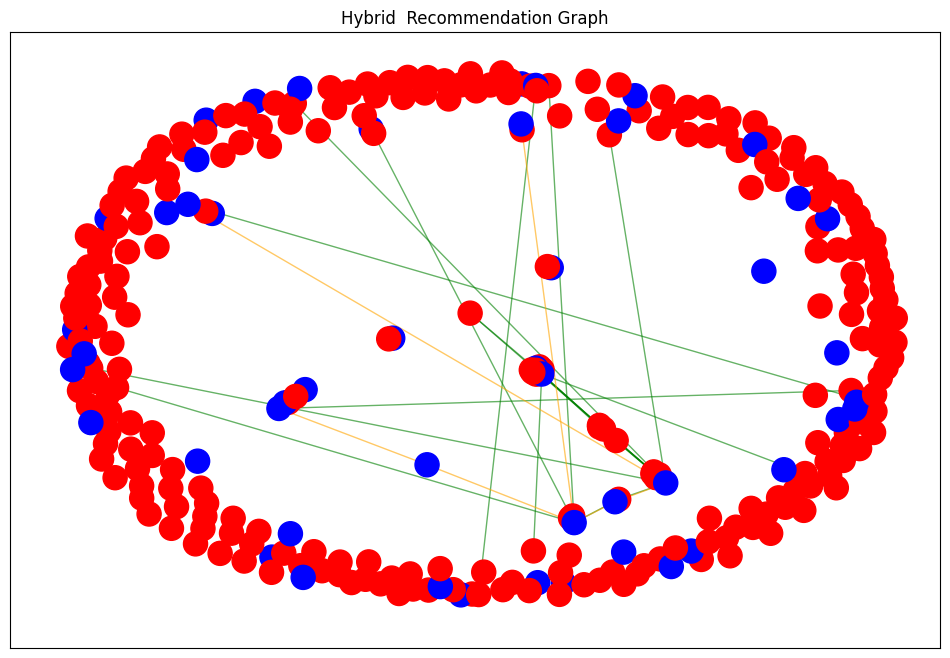

In [50]:


# Sample 300 random nodes 
sample_nodes = random.sample(list(G.nodes), 300)
subG = G.subgraph(sample_nodes)

 # Red = Users, Blue = Anime
node_colors = ["red" if G.nodes[n]["bipartite"] == 0 else "blue" for n in subG.nodes]

# Define edge colors
# Green edges → User → Anime (rating weight)
# Orange edges → Anime → Anime (similarity)
edge_colors = []
for u, v, data in subG.edges(data=True):
    
    if G.nodes[u]["bipartite"] == 1 and G.nodes[v]["bipartite"] == 1:  
        edge_colors.append("orange")  # Anime-Anime similarity
    else:
        edge_colors.append("green")

# layout
pos = nx.spring_layout(subG, seed=42)

plt.figure(figsize=(12, 8))


nx.draw_networkx_nodes(subG, pos, node_color=node_colors, node_size=300)

nx.draw_networkx_edges(subG, pos, edge_color=edge_colors, alpha=0.6)


plt.title("Hybrid  Recommendation Graph")
plt.show()


In [51]:


pytorch_graph = from_networkx(G)
pytorch_graph = pytorch_graph
print(pytorch_graph)

Data(edge_index=[2, 15721048], bipartite=[73515], type=[73515], weight=[15721048], num_nodes=73515)


In [ ]:
pca = PCA(n_components=32)
anime_embeddings = pca.fit_transform(np.vstack(anime_df["genre_embedding"].values))

num_nodes = pytorch_graph.num_nodes
node_features = torch.rand((num_nodes, 32)) 
anime_node_indices = anime_df["anime_id"].tolist()

node_features[anime_node_indices] = torch.tensor(anime_embeddings, dtype=torch.float)
pytorch_graph.x = node_features

edge_weights = [data["weight"] for _, _, data in G.edges(data=True)]
# pytorch_graph.y = torch.tensor(edge_weights + edge_weights, dtype=torch.float)  


In [ ]:

edge_weights = edge_weights + edge_weights  # Duplicate for both directions


num_edges = pytorch_graph.edge_index.shape[1]
pytorch_graph.z = torch.tensor(edge_weights[:num_edges], dtype=torch.float)

In [54]:
class GATModel(nn.Module):
    def __init__(self,in_channels,hidden_channels,out_channels,heads=1):
        super(GATModel,self).__init__()
        self.conv1 = GATConv(in_channels,hidden_channels,heads,dropout=0.2)
        self.conv2 = GATConv(heads*hidden_channels,out_channels,heads=1,dropout=0.2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.elu(x)  # Activation 
        x = self.conv2(x, edge_index)
        return x  

In [ ]:
import torch
import torch.nn.functional as F

model = GATModel(in_channels=32, hidden_channels=16, out_channels=8, heads=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)


for epoch in range(100):
    optimizer.zero_grad()
    out = model(pytorch_graph)  

    src_nodes = pytorch_graph.edge_index[0]  # Users
    dst_nodes = pytorch_graph.edge_index[1]  # Anime

    user_embeddings = out[src_nodes] 
    anime_embeddings = out[dst_nodes] 

    predicted_ratings = (user_embeddings * anime_embeddings).sum(dim=1)  

    loss = F.mse_loss(predicted_ratings, pytorch_graph.z)

    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 43.761375427246094
Epoch 2, Loss: 317.588623046875
Epoch 3, Loss: 26.848283767700195
Epoch 4, Loss: 44.72282409667969
Epoch 5, Loss: 43.609378814697266
Epoch 6, Loss: 38.600257873535156
Epoch 7, Loss: 30.308979034423828
Epoch 8, Loss: 20.18899917602539
Epoch 9, Loss: 14.798711776733398
Epoch 10, Loss: 24.554067611694336
Epoch 11, Loss: 33.9140510559082
Epoch 12, Loss: 24.191673278808594
Epoch 13, Loss: 15.966459274291992
Epoch 14, Loss: 15.947013854980469
Epoch 15, Loss: 18.2996826171875
Epoch 16, Loss: 19.37616539001465
Epoch 17, Loss: 18.457256317138672
Epoch 18, Loss: 16.308992385864258
Epoch 19, Loss: 15.7739839553833
Epoch 20, Loss: 18.61347198486328
Epoch 21, Loss: 19.297607421875
Epoch 22, Loss: 16.469886779785156
Epoch 23, Loss: 15.200440406799316
Epoch 24, Loss: 16.055147171020508
Epoch 25, Loss: 16.881912231445312
Epoch 26, Loss: 16.60541534423828
Epoch 27, Loss: 15.595728874206543
Epoch 28, Loss: 14.76240062713623
Epoch 29, Loss: 14.892595291137695
Epoch 30, L

In [60]:
torch.save(model.state_dict(), "gat_anime_recommendation.pth")
print("Model saved successfully!")


Model saved successfully!


In [66]:
model.eval()  


with torch.no_grad():
    node_embeddings = model(pytorch_graph) 
    
def get_watched_anime(user_id):
    # Get all anime this user has watched (rated anything, including -1)
    watched_anime = rating_df[rating_df["user_id"] == user_id]

    watched_list = [
        (anime_df.loc[anime_df['anime_id'] == anime_id, 'name'].values[0], rating)
        for anime_id, rating in zip(watched_anime["anime_id"], watched_anime["rating"])
    ]

    return watched_list


def predict_rating(user_id, anime_id):
    user_embedding = node_embeddings[user_id]  # Get user embedding
    anime_embedding = node_embeddings[anime_id]  # Get anime embedding
    
    # (dot product)
    predicted_rating = torch.dot(user_embedding, anime_embedding).item()
    
    return predicted_rating

def recommend_anime(user_id, top_k=5):
    anime_ids = anime_df["anime_id"].tolist()  
    recommendations = []

    for anime_id in anime_ids:
        rating = predict_rating(user_id, anime_id)
        recommendations.append((anime_id, rating))

    recommendations.sort(key=lambda x: x[1], reverse=True)

    # Convert anime IDs to names
    top_recommendations = [(anime_df.loc[anime_df['anime_id'] == anime_id, 'name'].values[0], rating)
                           for anime_id, rating in recommendations[:top_k]]

    return top_recommendations

def recommend_anime_with_watched(user_id, top_k=5):
    watched = get_watched_anime(user_id)  
    recommendations = recommend_anime(user_id, top_k)  

    print(f"\nUser {user_id} Watched These Anime:")
    for anime, rating in watched:
        print(f"- {anime} (Rated: {rating})")

    print(f"\nRecommended Anime for User {user_id}:")
    for anime, predicted_rating in recommendations:
        print(f"- {anime} (Predicted: {predicted_rating:.2f})")

    return recommendations
 


In [72]:
recommend_anime_with_watched(user_id=73510)



User 73510 Watched These Anime:
- Ai Yori Aoshi (Rated: 8)
- Final Approach (Rated: 7)
- Futakoi (Rated: 7)
- Green Green (Rated: 6)
- Kimi ga Nozomu Eien (Rated: 8)
- Maburaho (Rated: 7)
- Onegai☆Teacher (Rated: 7)
- Onegai☆Twins (Rated: 7)
- Sen to Chihiro no Kamikakushi (Rated: -1)
- Dragon Ball (Rated: 8)
- Dragon Ball GT (Rated: 8)
- Girls Bravo: First Season (Rated: 6)
- Bakuten Shoot Beyblade (Rated: 6)
- Iriya no Sora, UFO no Natsu (Rated: 7)
- Ai Yori Aoshi: Enishi (Rated: 8)
- Yu☆Gi☆Oh! Duel Monsters (Rated: 7)
- Girls Bravo: Second Season (Rated: 6)
- Tottoko Hamtarou (Rated: 5)
- Tonari no Totoro (Rated: 7)
- Pokemon (Rated: 7)
- Pokemon: Mewtwo no Gyakushuu (Rated: 8)
- Yu☆Gi☆Oh! (Rated: 6)
- Digimon Adventure (Rated: 6)
- Hotaru no Haka (Rated: 6)
- I&#039;&#039;s Pure (Rated: 7)
- Dragon Ball Z (Rated: 8)
- Kyou no 5 no 2 (Rated: 6)
- I&#039;&#039;s (Rated: 7)
- Pokemon: Maboroshi no Pokemon Lugia Bakutan (Rated: 7)
- Pokemon: Kesshoutou no Teiou Entei (Rated: 7)
- Poke

[('Mahou Shoujo Lyrical Nanoha A&#039;s', 6.62615966796875),
 ('Madang-Eul Naon Amtalg', 6.565988540649414),
 ('Haitai Nanafa', 6.556926727294922),
 ('Cowboy Bebop', 6.52147102355957),
 ('The Snack World (TV)', 6.518858909606934)]